# <center>Imports</center>

In [1]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, SGD, Adadelta, Lion, Nadam, Ftrl, AdamW
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

# Dataset
from keras.datasets import cifar10 as cifar

#Image Processing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from skimage.io import imsave
import cv2

#Utilities
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

# <center>Loading Data</center>

In [2]:
(xtr, ytr), (xt, yt) = cifar.load_data()

In [18]:
def prepareInputData(img):
    try:
        i = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        i = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        i = cv2.cvtColor(i, cv2.COLOR_GRAY2RGB)

        i = i.astype(np.float32)

        img_lab = cv2.cvtColor(i, cv2.COLOR_RGB2Lab)
        # resize the lightness channel to network input size 
        img_lab_rs = cv2.resize(img_lab, (32, 32)) # resize image to network input size
        img_l = img_lab_rs[:,:,0] # pull out L channel
        img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
        img_ab = img_ab/128
        return img_ab, img_l
        #The true color values range between -128 and 128. This is the default interval 
        #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
    except:
        print('Something wrong with image...')
        print("Image: ", img_ab)

In [102]:
X_train = []
y_train = []

X_test = []
y_test = []

In [103]:
for x in xtr:
    res = prepareInputData(x)
    X_train.append(np.expand_dims(res[1], axis=-1))
    y_train.append(res[0])


In [104]:
for t in xt:
    res = prepareInputData(t)
    X_test.append(np.expand_dims(res[1], axis=-1))
    y_test.append(res[0])

In [105]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# <center>Making the Model</center>

In [84]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2, (3, 3), activation='tanh', padding='same', strides=1)(my_model)

    return my_model


In [85]:
networkInput = Input(shape=(32, 32,1))
networkOutput = createModel(networkInput)
model = Model(inputs=networkInput, outputs=networkOutput)

In [86]:
def hue_bin_loss(y_true, y_pred):
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, tf.abs(y_pred - y_true)/8)

    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    sl = tf.abs(saturation_true - saturation_pred)

#    color_loss = 0.1*tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
#    total_loss = tf.add(color_loss, sl + hl)

    return tf.reduce_mean(sl + hl)  # Use reduce_mean to ensure a scalar loss value


In [87]:
LEARNING_RATE = 0.005
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss=hue_bin_loss)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_32 (Conv2D)          (None, 32, 32, 16)           160       ['input_5[0][0]']             
                                                                                                  
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 16)           0         ['conv2d_32[0][0]']           
                                                                                                  
 batch_normalization_28 (Ba  (None, 32, 32, 16)           64        ['leaky_re_lu_28[0][0]']      
 tchNormalization)                                                                          

In [96]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(32, 32, 3), 
                                                     weights='imagenet')
pretrained_model.trainable = False


In [97]:
pretrained_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss=hue_bin_loss)

In [98]:
def GenerateInputs(X_, y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1, 32, 32, 1)
        y_input = y_[i].reshape(1, 32, 32, 2)  # Fix: Correcting the reshape for labels
        yield (X_input, y_input)

history = pretrained_model.fit(
    GenerateInputs(X_train, y_train),
    epochs=150,
    verbose=1,
    steps_per_epoch=100,
    shuffle=True,
    validation_data=GenerateInputs(X_test, y_test),
    validation_steps=100
)


Epoch 1/150


ValueError: in user code:

    File "/Users/jordan/miniconda3/envs/colorization/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/var/folders/qt/4yhgm0j53w96n6z_j5zct2k40000gn/T/ipykernel_7316/570493544.py", line 17, in hue_bin_loss  *
        return tf.reduce_mean(sl + hl)  # Use reduce_mean to ensure a scalar loss value

    ValueError: Dimensions must be equal, but are 1024 and 2048 for '{{node hue_bin_loss/add_2}} = AddV2[T=DT_FLOAT](hue_bin_loss/Abs_1, hue_bin_loss/SelectV2)' with input shapes: [?,?,?,1024], [?,?,?,2048].


In [99]:
from keras import layers, models

In [108]:
def prepare_input_data(img):
    try:
        i = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        i = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        i = cv2.cvtColor(i, cv2.COLOR_GRAY2RGB)

        i = i.astype(np.float32)

        img_lab = cv2.cvtColor(i, cv2.COLOR_RGB2Lab)
        img_lab_rs = cv2.resize(img_lab, (32, 32))
        img_l = img_lab_rs[:, :, 0]
        img_ab = img_lab_rs[:, :, 1:]
        img_ab = img_ab / 128

        # Replicate the single channel to create a three-channel image
        img_l_three_channels = np.stack((img_l, img_l, img_l), axis=-1)

        return img_l_three_channels, img_ab
    except:
        print('Something wrong with the image...')

# Prepare data
X_train = []
y_train = []
X_test = []
y_test = []

for x in xtr:
    res = prepare_input_data(x)
    X_train.append(res[0])
    y_train.append(res[1])

for t in xt:
    res = prepare_input_data(t)
    X_test.append(res[0])
    y_test.append(res[1])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [113]:
def hue_bin_loss(y_true, y_pred):
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    # Resize the true values to match the size of the predicted values
    size = tf.shape(a_pred)[1:3]
    a_true = tf.image.resize(a_true, size)
    b_true = tf.image.resize(b_true, size)

    condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))
    condition2 = tf.logical_and(tf.greater(y_true, 0), tf.greater(y_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, tf.abs(y_pred - y_true) / 8)

    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    sl = tf.abs(saturation_true - saturation_pred)

    return tf.reduce_mean(sl + hl)


In [114]:
# Define the ResNet model
def build_resnet_model():
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))  # Output layer for ab channels

    return model

# Instantiate the model
model = build_resnet_model()

# Compile the model with your custom loss function
model.compile(optimizer='adam', loss=hue_bin_loss)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
evaluation_result = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation_result}")


Epoch 1/10


ValueError: in user code:

    File "/Users/jordan/miniconda3/envs/colorization/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/var/folders/qt/4yhgm0j53w96n6z_j5zct2k40000gn/T/ipykernel_7316/1249844473.py", line 10, in hue_bin_loss  *
        condition1 = tf.logical_and(tf.less(y_true, 0), tf.less(y_pred, 0))

    ValueError: Dimensions must be equal, but are 32 and 8 for '{{node hue_bin_loss/LogicalAnd}} = LogicalAnd[](hue_bin_loss/Less, hue_bin_loss/Less_1)' with input shapes: [?,32,32,2], [?,8,8,2].


In [115]:
def build_pix2pix_generator(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Middle
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    model = models.Model(inputs, outputs, name='pix2pix_generator')
    return model

In [130]:
def build_pix2pix_generator(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Middle
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output
    generated_image = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    model = models.Model(inputs, generated_image, name='pix2pix_generator')
    return model, generated_image

def build_pix2pix_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    outputs = layers.Conv2D(1, (4, 4), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name='pix2pix_discriminator')
    return model

In [131]:
# Build the Pix2Pix generator
generator, generated_image = build_pix2pix_generator(input_shape=(32, 32, 1))

# Build the Pix2Pix discriminator
discriminator = build_pix2pix_discriminator(input_shape=(32, 32, 3))

# Compile the models
generator.compile(optimizer='adam', loss='mae')
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Combine the generator and discriminator into a GAN model
discriminator.trainable = False
gan_input = layers.Input(shape=(32, 32, 1))
fake_image = generator(gan_input)

# Concatenate real and generated images
concatenated_images = layers.concatenate([gan_input, fake_image])

# Call the discriminator model with a single input tensor
gan_output = discriminator(concatenated_images)

# Define the GAN model
gan = models.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss=['binary_crossentropy', 'mae'], loss_weights=[1, 100])  # Adjust weights as needed

# Train the GAN
# ...


ValueError: Exception encountered when calling layer "pix2pix_discriminator" (type Functional).

Input 0 of layer "conv2d_107" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 32, 32, 4)

Call arguments received by layer "pix2pix_discriminator" (type Functional):
  • inputs=tf.Tensor(shape=(None, 32, 32, 4), dtype=float32)
  • training=None
  • mask=None

# <center>Testing the Model</center>

In [78]:
def ExtractTestInput(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (32, 32)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,32,32,1)
    
    return img_l_reshaped

In [79]:
def testColorization(path):
    # Load a sample test image
#    TestImagePath = "photos/val/val_data/ztBHq2Os5k0.jpg"
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))

    # Extract test input
    image_for_test = ExtractTestInput(img)

    # Make a prediction using the trained model
    Prediction = model.predict(image_for_test)
    Prediction = Prediction * 128
    Prediction = Prediction.reshape(32, 32, 2)

    # Create Lab image with L channel from original image and predicted a,b channels
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    img_lab_colorized = img_lab.copy()
    print(img.shape)
    img_lab_colorized[:, :, 1:] = Prediction

    newImg = np.array(image_for_test + Prediction)

    # Convert Lab image to RGB
    img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)
    img_colorized = cv2.resize(img_colorized, (256, 256))

    # Display the images
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, (256, 256))
    plt.imshow(img_original)
    plt.title("Original Image")
    plt.axis('off')

    # Colorized Image
    plt.subplot(1, 3, 2)
    plt.imshow(img_colorized)
    plt.title("Colorized Image")
    plt.axis('off')

    # Ground Truth Image
    plt.subplot(1, 3, 3)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
    img_gray = cv2.resize(img_gray, (256, 256))
    plt.imshow(img_gray)
    plt.title("Black & White Image")
    plt.axis('off')

    plt.show()


In [80]:
testers = X_test[:-100]

In [81]:
#testColorization("photos/val/val_data/ztBHq2Os5k0.jpg")
testColorization(testers[0])

TypeError: Can't convert object of type 'numpy.ndarray' to 'str' for 'filename'

1/1 [==============================] - 0s 101ms/step
(32, 32, 3)


2023-12-28 17:51:11.065855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


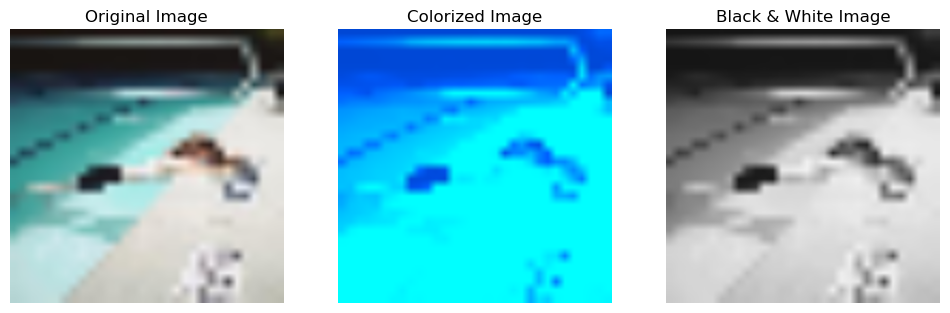

In [82]:
testColorization("photos/val/val_data/XsS6lqo5pno.jpg")

1/1 [==============================] - 0s 15ms/step
(32, 32, 3)


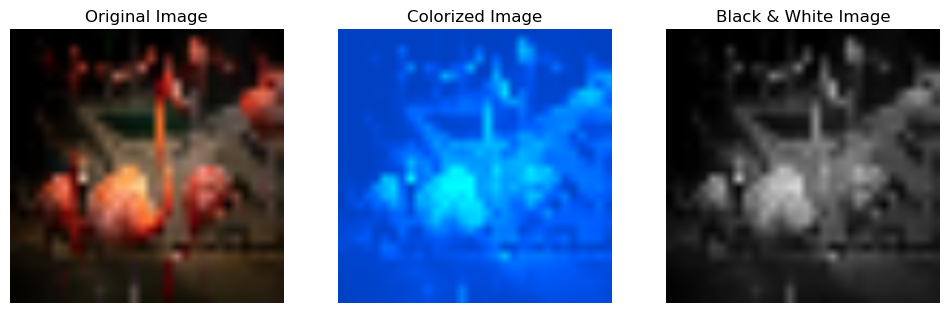

In [83]:
testColorization("photos/val/val_data/YLRmLiTMgSY.jpg")